In [252]:
import sys
sys.path.append("../")

In [253]:
from field_keypoints_detection.dataset_utils import download_data, coco_to_tfrecord_converter, load_tfrecords
from config import ROBOFLOW_API_KEY

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [254]:
download_data(api_key=ROBOFLOW_API_KEY,
              target_folder="data/keypoints/coco" ,
              workspace_name='roboflow-jvuqo',
              project_name='football-field-detection-f07vi',
              project_version=12,
              dtype='coco')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-field-detection-12 in coco:: 100%|██████████| 284/284 [00:00<00:00, 1154.97it/s]


In [255]:
tfrecords_path = 'data/keypoints/tfrecords'
os.makedirs(tfrecords_path, exist_ok=True)

for s in ['train', 'valid', 'test']:
    start = 'data/keypoints/coco'
    coco_to_tfrecord_converter(f'{start}/{s}/_annotations.coco.json', f'{start}/{s}', f'{tfrecords_path}/{s}.tfrecord')

{'football-field-detection': 0, 'pitch': 1}
TFRecord file saved at data/keypoints/tfrecords/train.tfrecord
{'football-field-detection': 0, 'pitch': 1}
TFRecord file saved at data/keypoints/tfrecords/valid.tfrecord
{'football-field-detection': 0, 'pitch': 1}
TFRecord file saved at data/keypoints/tfrecords/test.tfrecord


In [256]:
train_dataset = load_tfrecords("data/keypoints/tfrecords/train.tfrecord") 
val_dataset = load_tfrecords("data/keypoints/tfrecords/valid.tfrecord")
test_dataset = load_tfrecords("data/keypoints/tfrecords/test.tfrecord") 

# Plotting Data Example

In [257]:
def plot_examples(parsed_and_decoded_dataset, num_examples=1):

  for image, keypoints in parsed_and_decoded_dataset.take(num_examples):
    plt.figure(figsize=(12,7))
    plt.imshow(image.numpy())
    plt.axis(False)


    # Reshape the keypoints array to have shape (num_keypoints, 3)
    keypoints = keypoints.numpy()
    keypoints = keypoints.reshape(-1, 3)

    for i, keypoint in enumerate(keypoints):
      x, y, visibility = keypoint
      if visibility == 2:  # Only plot visible keypoints
        plt.scatter(x, y, s=50, c='red', marker='o')
        plt.text(x, y, str(i), fontsize=12, color='blue', ha='right', va='bottom')


    plt.show()

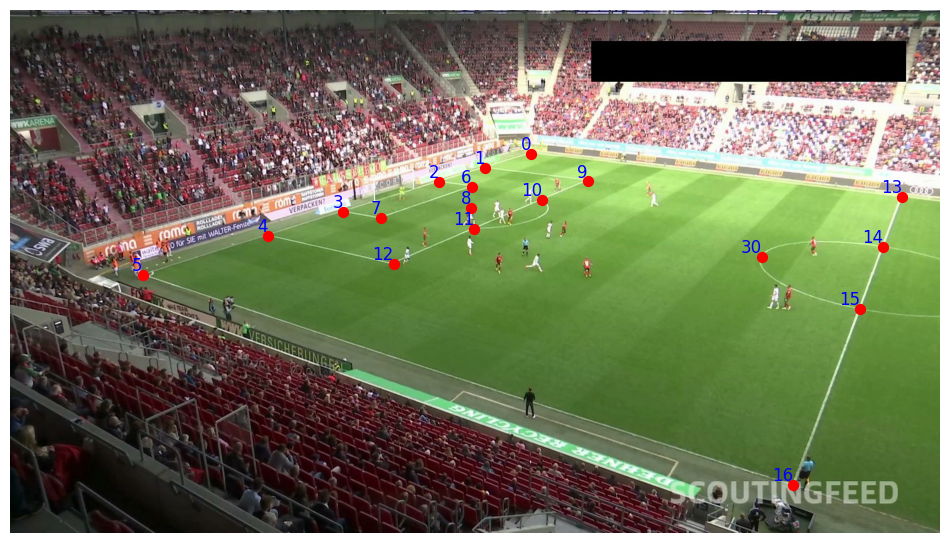

In [258]:
plot_examples(train_dataset)

# Calculating the Visibility of Each Keypoint

In [259]:
def calculate_visibility(dataset):
    keypoint_visibility_count = [0] * 32  # Assuming 32 keypoints
    total_examples = 0

    for image, keypoints in dataset:
        keypoints = keypoints.numpy().reshape(-1, 3)  # Reshape to (num_keypoints, 3)
        for i, keypoint in enumerate(keypoints):
            if keypoint[2] == 2:  # Visibility indicator
                keypoint_visibility_count[i] += 1
        total_examples += 1

    visibility_percentage = [(count / total_examples) * 100 for count in keypoint_visibility_count]
    return visibility_percentage

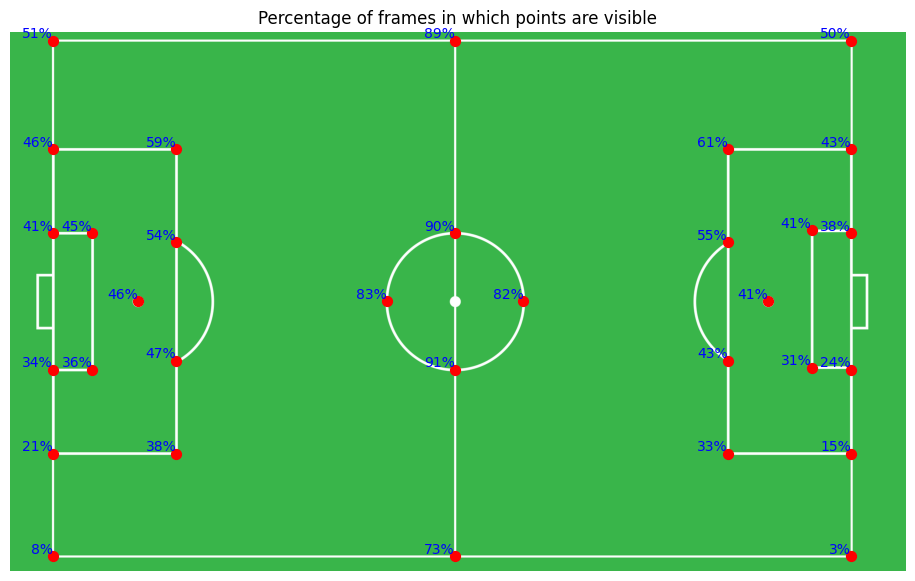

In [260]:
all_dataset = train_dataset.concatenate(val_dataset).concatenate(test_dataset)
visibility_percentage = calculate_visibility(all_dataset)

top_down_keypoints = np.array([
  [98, 19], [98, 268], [98, 460], [98, 773], [98, 964], [98, 1199], # 0-5
  [188, 460], [188, 773], # 6-7
  [292, 616], # 8
  [380, 268], [380, 481], [380, 752], [380, 964], # 9-12
  [1017, 19], [1017, 460], [1017, 773], [1017, 1199], # 13-16
  [1641, 268], [1641, 481], [1641, 752], [1641, 964], # 17-20
  [1733, 616], # 21
  [1833, 453], [1833, 767], # 22-23
  [1923, 19], [1923, 268], [1923, 460], [1923, 773], [1923, 964], [1923, 1199], # 24-29
  [861, 616], [1174, 616] # 30-31
])

template = cv2.imread('data/2d_football_pitch.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,7))
plt.title("Percentage of frames in which points are visible")
plt.axis(False)
plt.imshow(template)

for i, percentage in enumerate(visibility_percentage):
  plt.scatter(top_down_keypoints[i][0], top_down_keypoints[i][1], s=50, c='red', marker='o')
  plt.text(top_down_keypoints[i][0], top_down_keypoints[i][1], f'{round(percentage)}%', fontsize=10, color='blue', ha='right', va='bottom')

plt.savefig('../output_videos/percentage_of_visible_frames_for_each_point.png')
plt.show()

# Plotting The Field Projection

In [261]:
def create_radial_gradients(template_shape, keypoints, scale_factor=.01):
    """
    Create radial gradients centered at the given keypoints.

    Arguments:
        template_shape: tuple (height, width), shape of the template image
        keypoints: np.array of shape (N, 2), coordinates of keypoints
        scale_factor: float, scaling factor for gradient strength

    Returns:
        radial_gradients: np.array of shape (height, width), the combined radial gradients
    """

    height, width = template_shape
    radial_gradients = np.zeros((height, width), dtype=np.float32)
    
    for keypoint in keypoints:
        kp_x, kp_y = keypoint
        
        # Generate x and y coordinates centered at the keypoint
        y = np.linspace(0, height - 1, height)
        x = np.linspace(0, width - 1, width)
        x_coord, y_coord = np.meshgrid(x, y)
        
        # Calculate the distance from the keypoint
        distances = np.sqrt((x_coord - kp_x) ** 2 + (y_coord - kp_y) ** 2)
        
        # Apply the radial gradient with scaling factor
        radial_gradient = np.exp(-distances * scale_factor)
        
        # Add the radial gradient to the overall radial gradients
        radial_gradients = np.maximum(radial_gradients, radial_gradient)
    
    # Normalize the combined radial gradients
    radial_gradients = np.clip(radial_gradients, 0, 1)
    
    return radial_gradients

def rgb_template_to_radial_gradient_template(rgb_template, keypoints, scale_factor=.01):
    """
    Convert an RGB template image to a radial gradient template with gradients centered at keypoints.

    Arguments:
        rgb_template: np.array of shape (H, W, 3), RGB template image
        keypoints: np.array of shape (N, 2), coordinates of keypoints
        scale_factor: float, scaling factor for gradient strength

    Returns:
        radial_gradient_template: np.array of shape (H, W, 3), the radial gradient template
    """
    
    # Convert to grayscale by averaging the RGB channels
    rgb_template = np.mean(rgb_template, axis=2)
    
    # Create radial gradients for the keypoints
    radial_gradients = create_radial_gradients(rgb_template.shape, keypoints, scale_factor)
    
    # Stack the grayscale template with the radial gradients
    radial_gradient_template = np.stack((rgb_template, radial_gradients, radial_gradients), axis=2)
    
    return radial_gradient_template

In [262]:
def resize_keypoints(keypoints, original_width, original_height, new_width, new_height):
    """
    Resize keypoints from the original image dimensions to new dimensions.

    Arguments:
        keypoints: np.array of shape (N, 2), coordinates of keypoints in the original image
        original_width: int, width of the original image
        original_height: int, height of the original image
        new_width: int, width of the new image dimensions
        new_height: int, height of the new image dimensions

    Returns:
        resized_keypoints: np.array of shape (N, 2), coordinates of keypoints resized to the new image dimensions
    """
    # Calculate the scaling factors for width and height
    scale_x = new_width / original_width
    scale_y = new_height / original_height
    
    # Apply the scaling factors to the keypoints
    resized_keypoints = keypoints * np.array([scale_x, scale_y])
    
    return resized_keypoints

In [263]:
def visualize(image, label=""):
    """
    Plot an image with label

    Arguments:
        image: image to plot,
        label: plot title
    Returns:

    """
    plt.figure(figsize=(8, 5))
    plt.title(label)
    plt.axis(False)
    plt.imshow(image)
    plt.show()


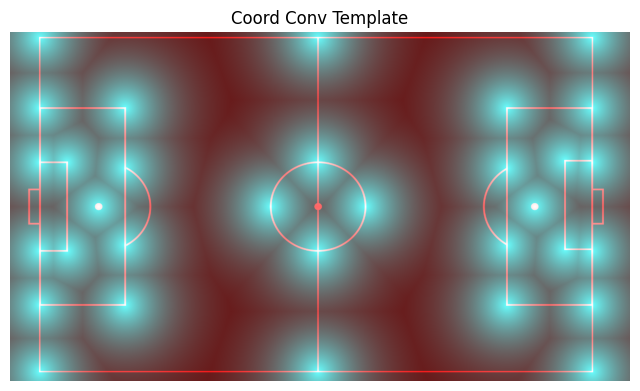

In [264]:
# Normalize and resize field image
template = cv2.imread('data/2d_football_pitch.png')
height, width, _ = template.shape
top_down_keypoints_resized = resize_keypoints(top_down_keypoints, width, height, 1280, 720)
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.

# Apply Coord Conv to Template image
radial_gradient_template = rgb_template_to_radial_gradient_template(template, top_down_keypoints_resized, scale_factor=.01)

visualize(radial_gradient_template, "Coord Conv Template")

In [265]:
def compute_homography(src_points, dst_points):
    """
    Compute a single homography matrix between source and destination points.

    Arguments:
        src_points: numpy array of shape (n, 2) - source points coordinates
        dst_points: numpy array of shape (n, 2) - destination points coordinates

    Returns:
        homography: numpy array of shape (3, 3) - the homography matrix
    """
    # Compute the homography matrix using RANSAC
    homography, _ = cv2.findHomography(src_points, dst_points, cv2.LMEDS, 5)
    
    return homography

In [266]:
import cv2
import numpy as np

def warp_image(image, H, output_shape=None):
    """
    Warp an image using a homography matrix.

    Arguments:
        image: numpy array of shape (height, width, n_channels) - the image to be warped
        H: numpy array of shape (3, 3) - the homography matrix to apply
        output_shape (optional): tuple of (height, width) - output shape of the warped image

    Returns:
        numpy array of shape (height2, width2, n_channels) - the warped image
    """
    if output_shape is None:
        output_shape = image.shape[:2]

    return cv2.warpPerspective(image, H, dsize=output_shape)


In [267]:
def merge_template(image, warped_template):
    """
    Merge an image with a warped template by averaging overlapping regions.

    Arguments:
        image: numpy array of shape (height, width, n_channels) - the base image
        warped_template: numpy array of shape (height, width, n_channels) - the warped template to overlay

    Returns:
        numpy array of shape (height, width, n_channels) - the merged image
    """
    # Create a mask where the warped template has non-zero values
    mask = warped_template[:, :, 0] > 0.0
    
    # Average the overlapping regions
    merged_image = np.copy(image)
    merged_image[mask] = (image[mask].astype("float32") + warped_template[mask].astype("float32")) / 2
    
    return merged_image

In [268]:
def homography_visualization(image, keypoints, template, top_down_keypoints, width, height):
    """
    Apply homography to warp a template image and visualize it over a base image.

    Arguments:
        image: numpy array of shape (height, width, n_channels) - the base image
        keypoints: numpy array of shape (n, 3) - keypoints in the base image, with visibility flag
        template: numpy array of shape (height, width, n_channels) - the template image to warp
        top_down_keypoints: numpy array of shape (n, 2) - keypoints in the template image

    Returns:
        None
    """
    # Resize top-down keypoints to match the base image dimensions
    resized_keypoints = resize_keypoints(top_down_keypoints, width, height, 1920, 1080)
    
    # Create source and destination points for homography
    src_points = []
    dst_points = []
    for i, kp in enumerate(keypoints):
        if kp[2] != 0:  # Check if the keypoint is visible
            dst_points.append(kp[:2])
            src_points.append(resized_keypoints[i])
    
    src_points = np.array(src_points)
    dst_points = np.array(dst_points)
    
    # Compute homography matrix
    homography = compute_homography(src_points, dst_points)
    
    # Warp the template image using the homography matrix
    warped_template = warp_image(cv2.resize(template, (1920, 1080)), homography, output_shape=(1920, 1080))
    
    # Merge the warped template with the base image
    merged_image = merge_template(image / 255.0, cv2.resize(warped_template, (1920, 1080)))
    
    # Visualize the result
    visualize(merged_image)

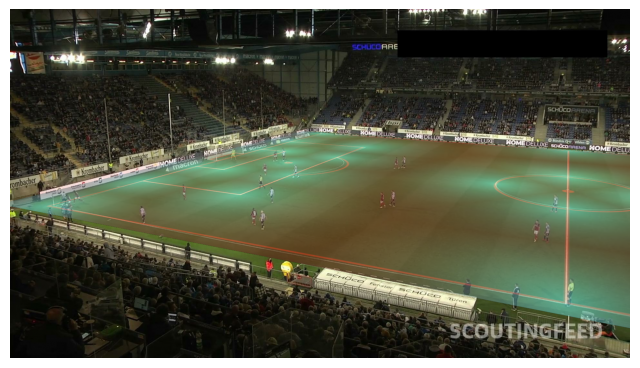

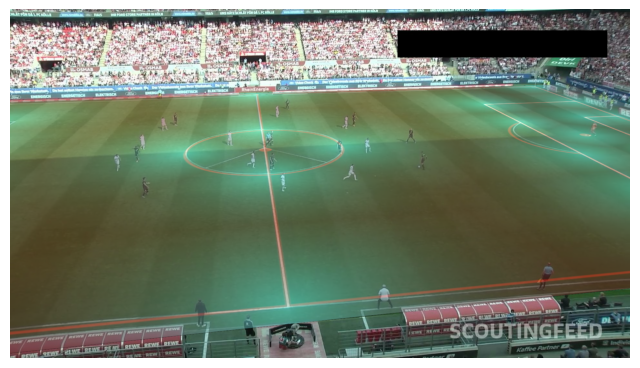

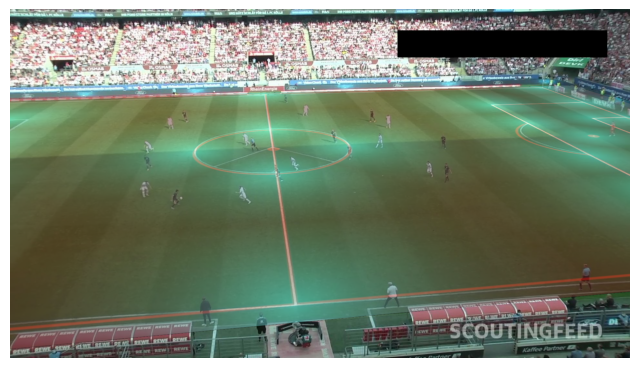

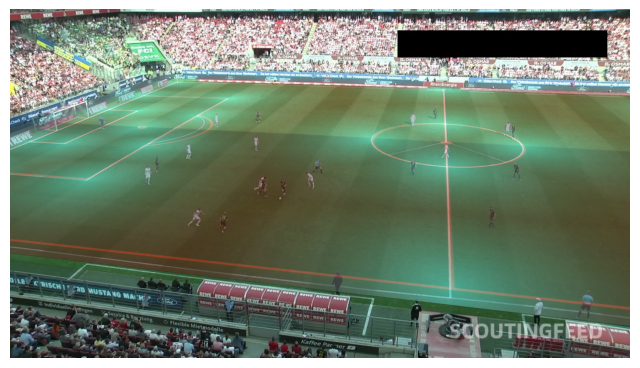

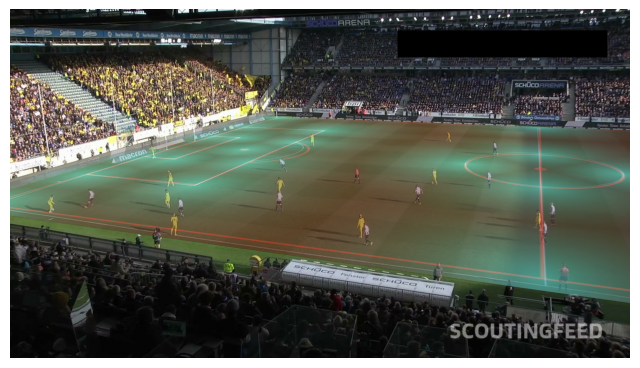

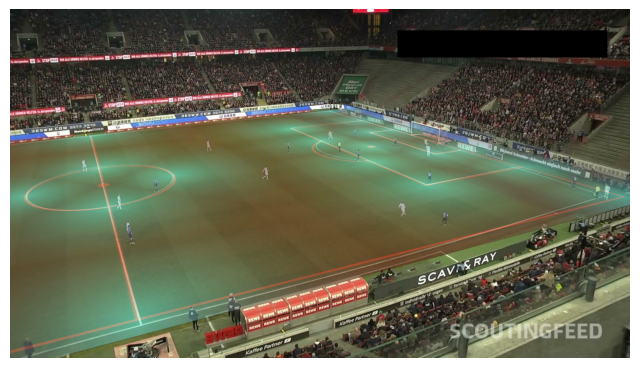

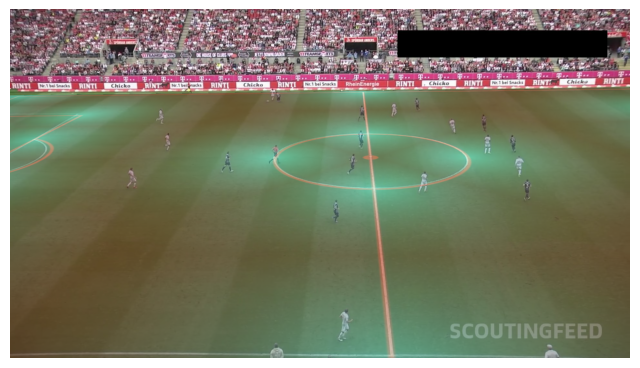

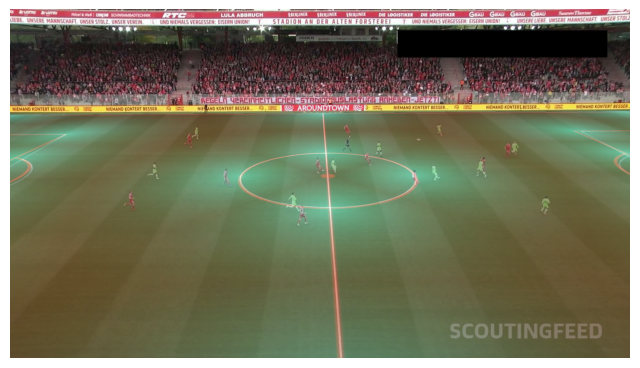

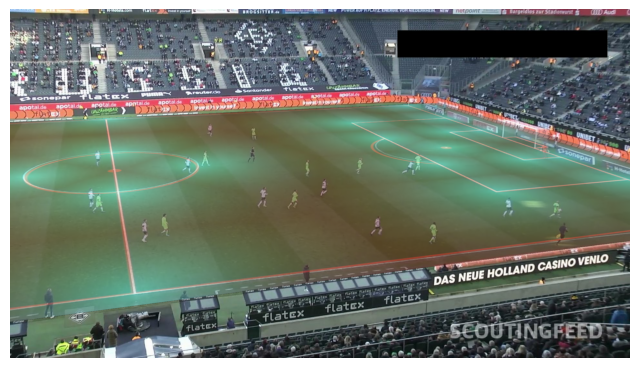

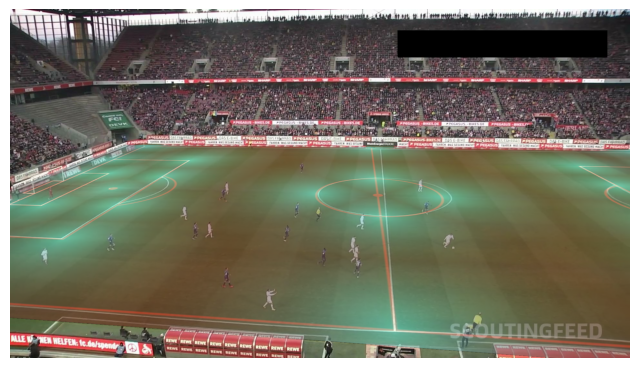

In [269]:
keypoints = []
image = []
for img, k in test_dataset.take(10):
    keypoints = k.numpy().reshape(-1, 3)
    image = img.numpy()
    homography_visualization(image, keypoints, radial_gradient_template, top_down_keypoints, width, height)
